# Forecast Maximum Rainfall 

## Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
from pprint import pprint

from ts.data.dataset import SeattleRainfall
from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

/Users/ahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Load Dataset

In [3]:
rainfall_df = SeattleRainfall.loadData('~/Downloads/Datasets/SeattleRainfall')
rainfall_df

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25546,2017-12-10,0.00,49,34,False
25547,2017-12-11,0.00,49,29,False
25548,2017-12-12,0.00,46,32,False
25549,2017-12-13,0.00,48,34,False


In [12]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = row[0].date()

### Plot Entire Data

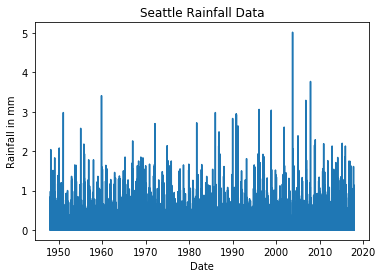

In [13]:
plt.plot(date_series, rainfall_df['PRCP'].to_numpy())
plt.title('Seattle Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

## Computing Monthly Max Rainfall

Data Type: float64, Data Shape: (840,)

First 10 data points:
[0.74, 0.98, 2.04, 0.7, 0.88, 0.92, 0.44, 0.41, 1.51, 0.66]

Last 10 data points:
[0.81, 0.85, 0.47, 1.05, 0.0, 0.02, 0.16, 1.61, 1.14, 0.79]


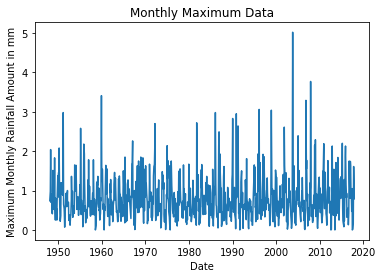

In [16]:
month_max_series = [rainfall_df.iloc[0]['PRCP']]
month_date_series = [date_series[0]]

for index, row in rainfall_df.iloc[1:].iterrows():
    
    if date_series[index].month == date_series[index - 1].month:
        if month_max_series[-1] < row['PRCP']:
            month_max_series[-1] = row['PRCP']
            month_date_series[-1] = date_series[index]
        
    else:
        month_max_series.append(row['PRCP'])
        month_date_series.append(date_series[index])
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_date_series, month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Date')
plt.ylabel('Maximum Monthly Rainfall Amount in mm')
plt.show()

In [20]:
train_frac = 0.90
n = month_max_series.shape[0]
num_train = int(n * train_frac)

print(f'Train Size: {num_train}, Test Size: {n - num_train}')

Train Size: 756, Test Size: 84


## Decompose the time series into trend, seasonality and remainder components

In [21]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [22]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

### Plot Time Series Components

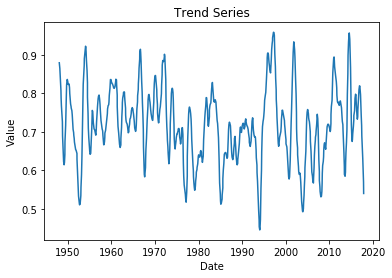

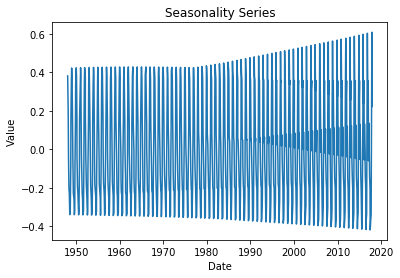

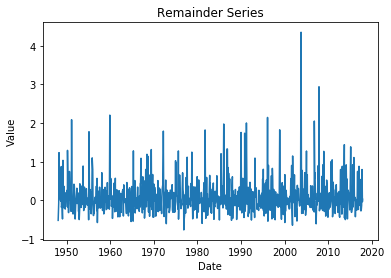

In [23]:
plt.plot(month_date_series, trend_series)
plt.title('Trend Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, seasonality_series)
plt.title('Seasonality Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, remainder_series)
plt.title('Remainder Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Compare the inferred seasonality with actual data

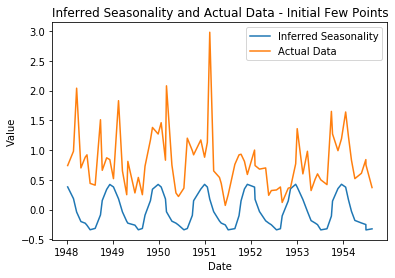

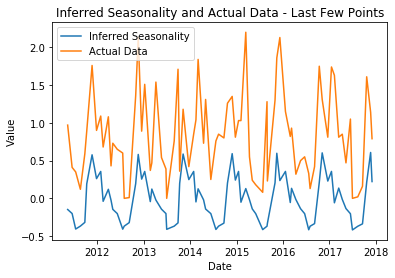

In [24]:
# Front Few Points
num_initial_points = 80

plt.plot(
    month_date_series[:num_initial_points],
    seasonality_series[:num_initial_points], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[:num_initial_points],
    month_max_series[:num_initial_points], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(
    month_date_series[-num_last_points:],
    seasonality_series[-num_last_points:], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[-num_last_points:],
    month_max_series[-num_last_points:], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.show()

## Parameter Estimation of GEV fitted to Remainder Series

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: 0.08183628067043341 
Location Parameter: -0.10597773474413826 
Scale Parameter: 0.29901052479450774 
Log Likelihood: -311.1098888464239


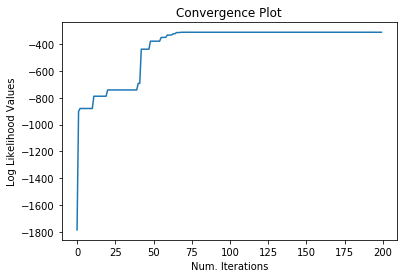

In [25]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [26]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

### Plot PDF and CDF

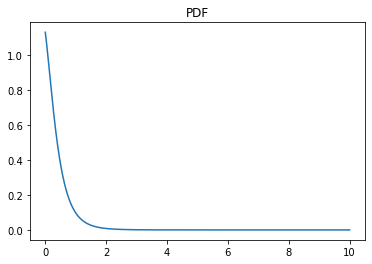

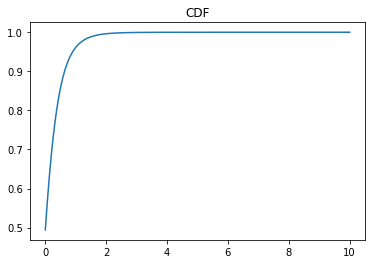

In [29]:
x = np.linspace(0, 10, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

## Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (840, 1)

First 5 data points:
array([[0.01295716],
       [0.41341178],
       [0.97826563],
       [0.5735161 ],
       [0.76007586]])

Last 5 data points:
array([[0.17294325],
       [0.33530599],
       [0.93483763],
       [0.4510027 ],
       [0.52517652]])


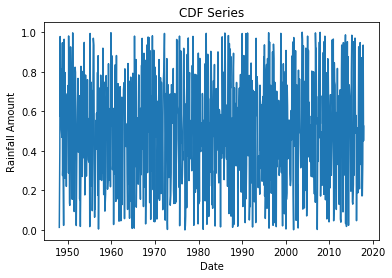

In [28]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(month_date_series, remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Date')
plt.ylabel('Rainfall Amount')
plt.show()

## Model for Forecasting next day CDF

### Model Architecture

In [82]:
lag = 20

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 70, 0.99
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [83]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (736, 20)
Output Data Shape: (736, 1)


Epoch 1/200
23/23 [==============================] - 0s 730us/step - loss: 0.0759
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0760
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0750
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0722
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0736
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0752
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0732
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0729
Epoch 11/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0703
Epoch 12/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0721
Epoch 13/200
23/23 [===============

23/23 [==============================] - 0s 990us/step - loss: 0.0375
Epoch 102/200
23/23 [==============================] - 0s 894us/step - loss: 0.0398
Epoch 103/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 104/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 105/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 106/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 107/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0350
Epoch 108/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 109/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0368
Epoch 110/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0337
Epoch 111/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 112/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 113/200
23/23 [=====

23/23 [==============================] - 0s 1ms/step - loss: 0.0205


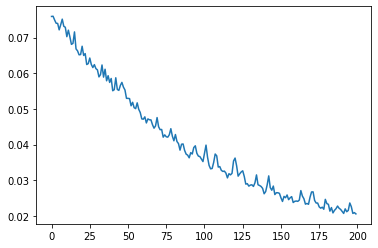

In [84]:
history = model.fit(input_data, output_data, epochs=200)
plt.plot(history.history['loss'])

### Forecast training data

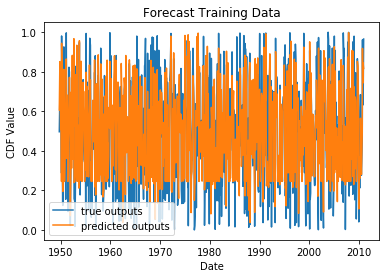

In [85]:
remainder_train_cdf = model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(
    month_date_series[lag: num_train], 
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Value')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

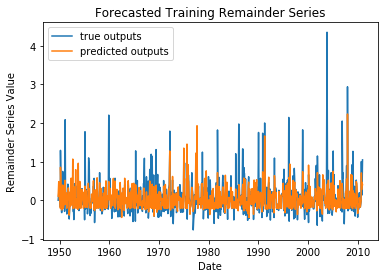

In [86]:
plt.plot(
    month_date_series[lag: num_train],
    remainder_series[lag: num_train],
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Training Remainder Series')
plt.show()

### Forecast test data

In [87]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (84, 20)
Test Output Data Shape: (84, 1)


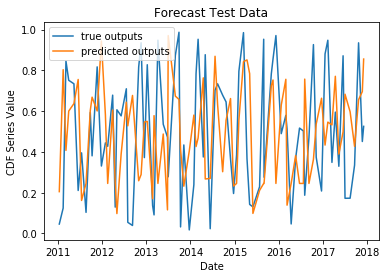

In [88]:
remainder_test_cdf = model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(
    month_date_series[num_train:],
    test_output, 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Series Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

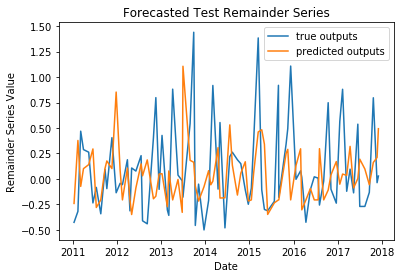

In [89]:
plt.plot(
    month_date_series[num_train:],
    remainder_series[num_train:], 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Test Remainder Series')
plt.show()

## Forecasting Trend

### Model Architecture

In [100]:
lag = 20

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [101]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (736, 20)
Output Data Shape: (736, 1)


Epoch 1/100
23/23 [==============================] - 0s 770us/step - loss: 0.1329
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 7.9511e-04
Epoch 13/100
23/23 [===========

23/23 [==============================] - 0s 686us/step - loss: 2.0120e-04
Epoch 98/100
23/23 [==============================] - 0s 723us/step - loss: 2.0052e-04
Epoch 99/100
23/23 [==============================] - 0s 744us/step - loss: 1.9782e-04
Epoch 100/100
23/23 [==============================] - 0s 785us/step - loss: 1.9647e-04


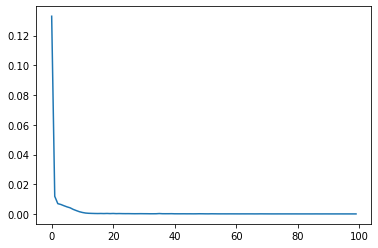

In [102]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

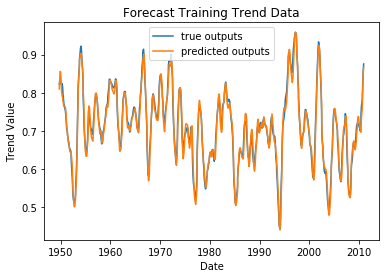

In [103]:
trend_train = model_trend.predict(input_data)

plt.plot(
    month_date_series[lag: num_train],
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train],
    trend_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

### Forecast test data

In [104]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (84, 20)
Test Output Data Shape: (84, 1)


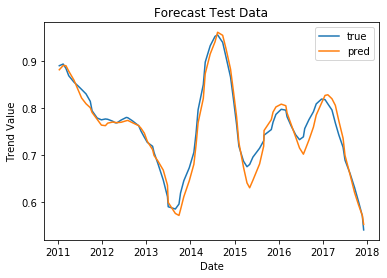

In [105]:
trend_test = model_trend.predict(test_input)

plt.plot(
    month_date_series[num_train:], 
    test_output, 
    label='true'
)
plt.plot(
    month_date_series[num_train:], 
    trend_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Seasonality

### Forecast training data

In [106]:
seasonality_train = seasonality_series[:num_train][lag:]

### Forecast test data

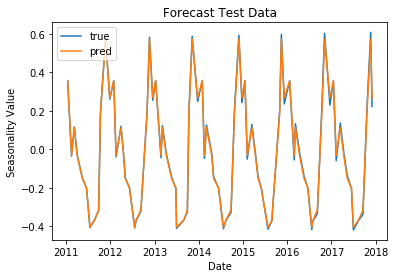

In [107]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(
    month_date_series[num_train:],
    seasonality_series[num_train:], 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    seasonality_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Seasonality Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecast Maximum Rainfall

In [108]:
print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(736, 1) (736, 1) (736, 1)
(84, 1) (84, 1) (84, 1)


### Forecast training data

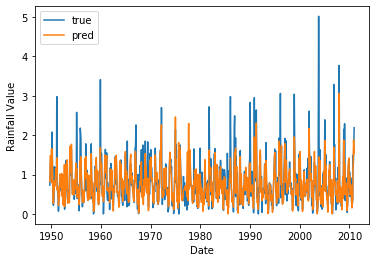

In [109]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag:]

plt.plot(
    month_date_series[lag: num_train],
    true_train, 
    label='true'
)
plt.plot(
    month_date_series[lag: num_train],
    pred_train, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()

### Forecast test data

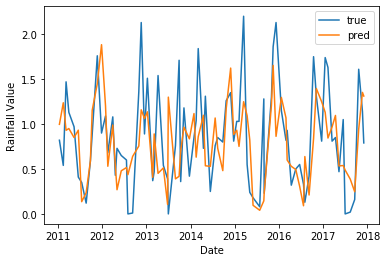

In [110]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(
    month_date_series[num_train:],
    true_test, 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    pred_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()